In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib as mpl
import matplotlib
from IPython.display import display

import matplotlib.pylab as pylab

from matplotlib import rc

import torch
from torch.nn.functional import log_softmax
from sklearn.model_selection import KFold
from scipy.optimize import minimize
from matplotlib.lines import Line2D
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True

# Read logs

In [10]:
path = './logs_imagenet/'
df = pd.concat([pd.read_csv(path + f) for f in os.listdir(path)], sort=False)
dfbase = df.groupby(
    ['dataset', 'model', 'method', 'n_samples', 'metric', 'info']
).value.agg(['mean']).reset_index()

In [11]:
colors = {'efficientnet_b2': 'r',
          'resnet50': 'g',
          'tf_efficientnet_b5': 'b'
         }
short_legend_augs = {'cf':  'CF',
                     'ra':  'GPS',
                     '5c':  '5C',
                     '10c': '10C',
                     'cc':  'CC'}
model_names = {'efficientnet_b2': 'Efficientnet B2',
              'resnet50': 'ResNet50',
              'tf_efficientnet_b5': 'Efficientnet B5',
              'tf_efficientnet_l2_ns_475': 'Efficientnet L2-475'}
metric_names = {'ll': 'Calibrated log-likelihood',
                'acc': 'Top-1 accuracy (\%)'}
# colors_augs = {'cf': 0, 'ra': 2, 'cc': 3, '5c': 5, '10c': 6}

colors_augs = {'cf': 0,
             'MGrid': 1,
             'ra': 2,
             'cc': 3,
             'MTrain': 4,
             '5c': 6,
             '10c': 7}
colors_palette = [
    '#bcbd22', '#e377c2', '#9467bd',
    '#8c564b', '#1f77b4', '#d62728',
    '#2ca02c', '#ff7f0e', '#7f7f7f']
dataset_names = {'ImageNet': 'ImageNet'}

In [12]:
df = dfbase

# SETUP1 - CIFAR IN-DOMAIN

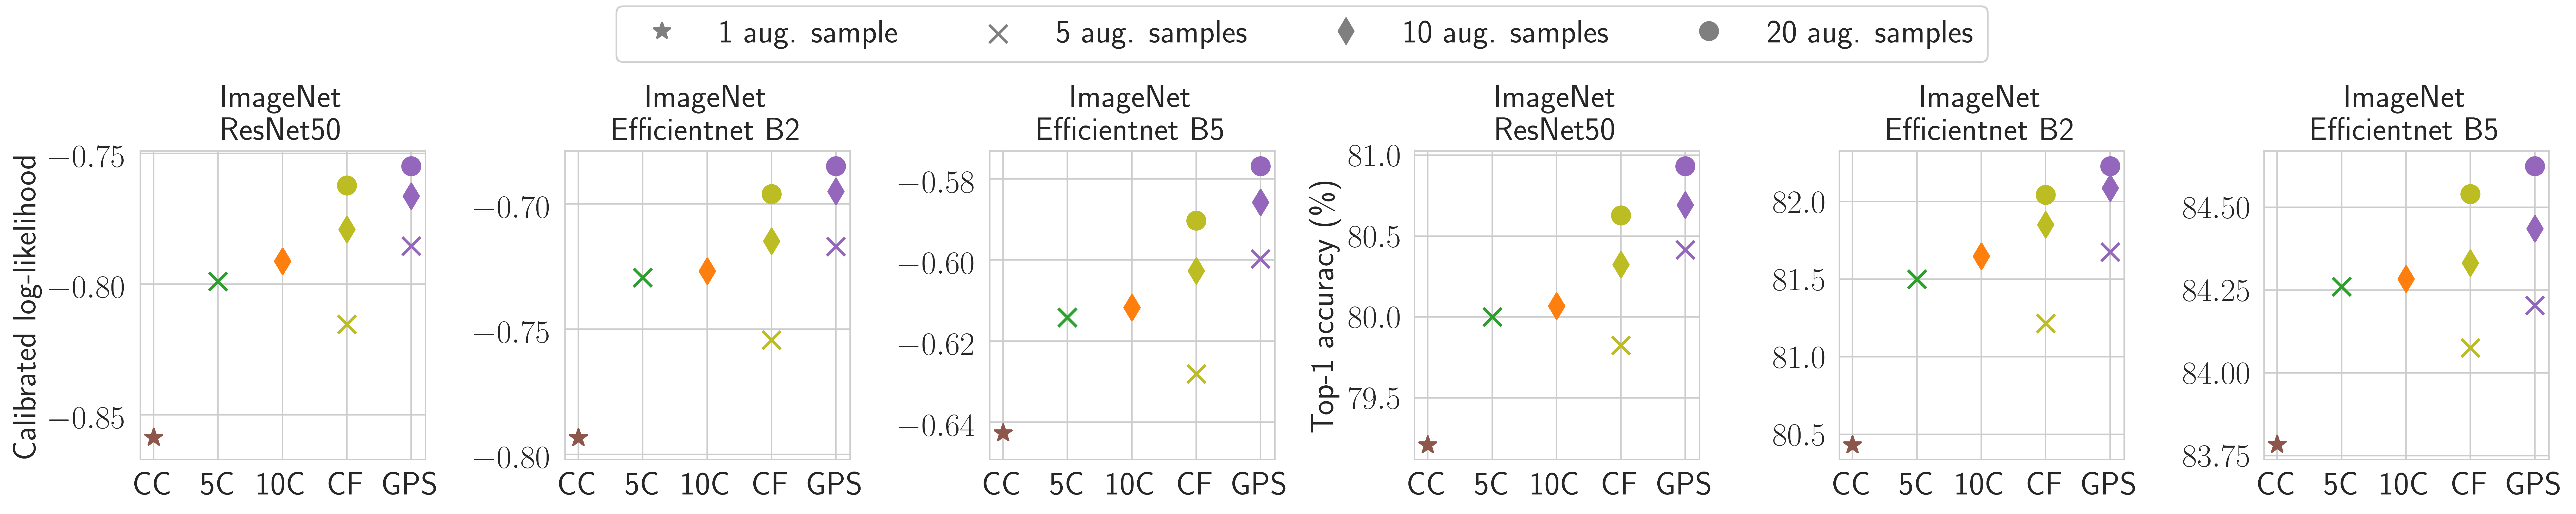

In [13]:
mpl.rcParams['figure.dpi'] = 500
f = plt.figure(figsize=(20, 3.5))

for m, metric in enumerate(['ll', 'acc']):
    params = {'legend.fontsize': 18,
             'axes.labelsize': 18,
    #          'figure.figsize': (6, 4),
             'axes.titlesize':18,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'lines.markersize': 10,
             'legend.markerscale': 1.,
             'legend.labelspacing': 1.,
             'figure.subplot.hspace': 0.3,
             'figure.subplot.wspace': 0.05,
             }
    pylab.rcParams.update(params)
    models = ['resnet50', 'efficientnet_b2', 'tf_efficientnet_b5']#, 'tf_efficientnet_l2_ns_475']
    augs = [ 'cc', '5c', '10c', 'cf', 'ra']
    sample_nums = [5, 10, 20]
    datasets = ['ImageNet']
   
    i = 1
    short_legend_augs_ordered = []
    for aug in augs:
        short_legend_augs_ordered.append(short_legend_augs[aug])

    for dataset in datasets:
        for model in models:
            plt.subplot(len(datasets), len(models)*2, m*3+i)
            i += 1
            lines = []
            for j, aug in enumerate(augs):
                plot_augs = []
                legends = []
                for sample_num in sample_nums:
                    marker = 'o'
                    if aug != 'cc' or sample_num == 20:
                        if aug == 'cc':
                            sample_num = 1
                            marker = '*'
                        if aug == '5c':
                            sample_num = 5
                            marker = 'x'
                        if aug == '10c':
                            sample_num = 10
                            marker = 'd'
                        if sample_num == 5 and (aug == 'ra' or aug == 'cf'):
                            marker = 'x'
                        if sample_num == 10 and (aug == 'ra' or aug == 'cf'):
                            marker = 'd' 
                        
                        if model == 'tf_efficientnet_l2_ns_475' and aug == 'ra':
                            for qw, inf in enumerate(['pols/resnet50_ll.npy', 
                                                      'pols/efficientnet_b2_ll.npy', 
                                                      'pols/tf_efficientnet_b5_ll.npy']):
                                q = 'dataset=="%s" and model=="%s" and method=="%s" and metric=="%s" and n_samples==%d and info=="%s"' % (dataset, model, aug, metric, sample_num, inf)
                                val = df.query(q)['mean']
                                val = val.item()
                                val *= 100 if metric == 'acc' else 1

                                pos_x = j+qw + 0.2 * ((sample_num < 100) - 0.5) * (len(sample_nums) == 2)                    
                                plt.scatter([pos_x], [val], c=colors_palette[colors_augs[aug]], marker=marker,)
                                legends.append(plt.scatter([pos_x], [val], marker=marker,
                                            c=colors_palette[colors_augs[aug]]))
                        else:
                            q = 'dataset=="%s" and model=="%s" and method=="%s" and metric=="%s" and n_samples==%d' % (dataset, model, aug, metric, sample_num)
                            val = df.query(q)['mean']
                            val = val.item()
                            val *= 100 if metric == 'acc' else 1

                            pos_x = j + 0.2 * ((sample_num < 100) - 0.5) * (len(sample_nums) == 2)                    
                            plt.scatter([pos_x], [val], c=colors_palette[colors_augs[aug]], marker=marker)
                            legends.append(plt.scatter([pos_x], [val], marker=marker,
                                        c=colors_palette[colors_augs[aug]]))
                            
        
                plt.title(r'ImageNet'+'\n'+model_names[model])
                plt.xticks(np.arange(len(augs)), short_legend_augs_ordered)
                if model == 'tf_efficientnet_l2_ns_475':
                    ww = [r'GPS''\n'r'RN 50', r'GPS''\n'r'B2', r'GPS''\n'r'EN B5']
                    plt.xticks(list(range(len(augs)))+[5, 6], short_legend_augs_ordered[:-1]+ww, fontsize=15)
                if i % (len(models)) == 2:
                    plt.ylabel(metric_names[metric])
    handles = []
    circle = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker='*', linestyle='None',
                              label='1 aug. sample')
    handles.append(circle)
    cross = plt.scatter([np.nan], [np.nan], color=colors_palette[-1], marker='x', 
                               label='5 aug. samples')
    handles.append(cross)
    circle = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker='d', linestyle='None',
                              label='10 aug. samples')
    handles.append(circle)
    circle = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker='o', linestyle='None',
                              label='20 aug. samples')
    handles.append(circle)

    f.legend(handles=handles, loc='upper center', ncol=4,
                bbox_to_anchor=(0.5, 1.15))
plt.tight_layout()
# plt.subplot_tool()
plt.savefig('imagenet.pdf', bbox_inches='tight')

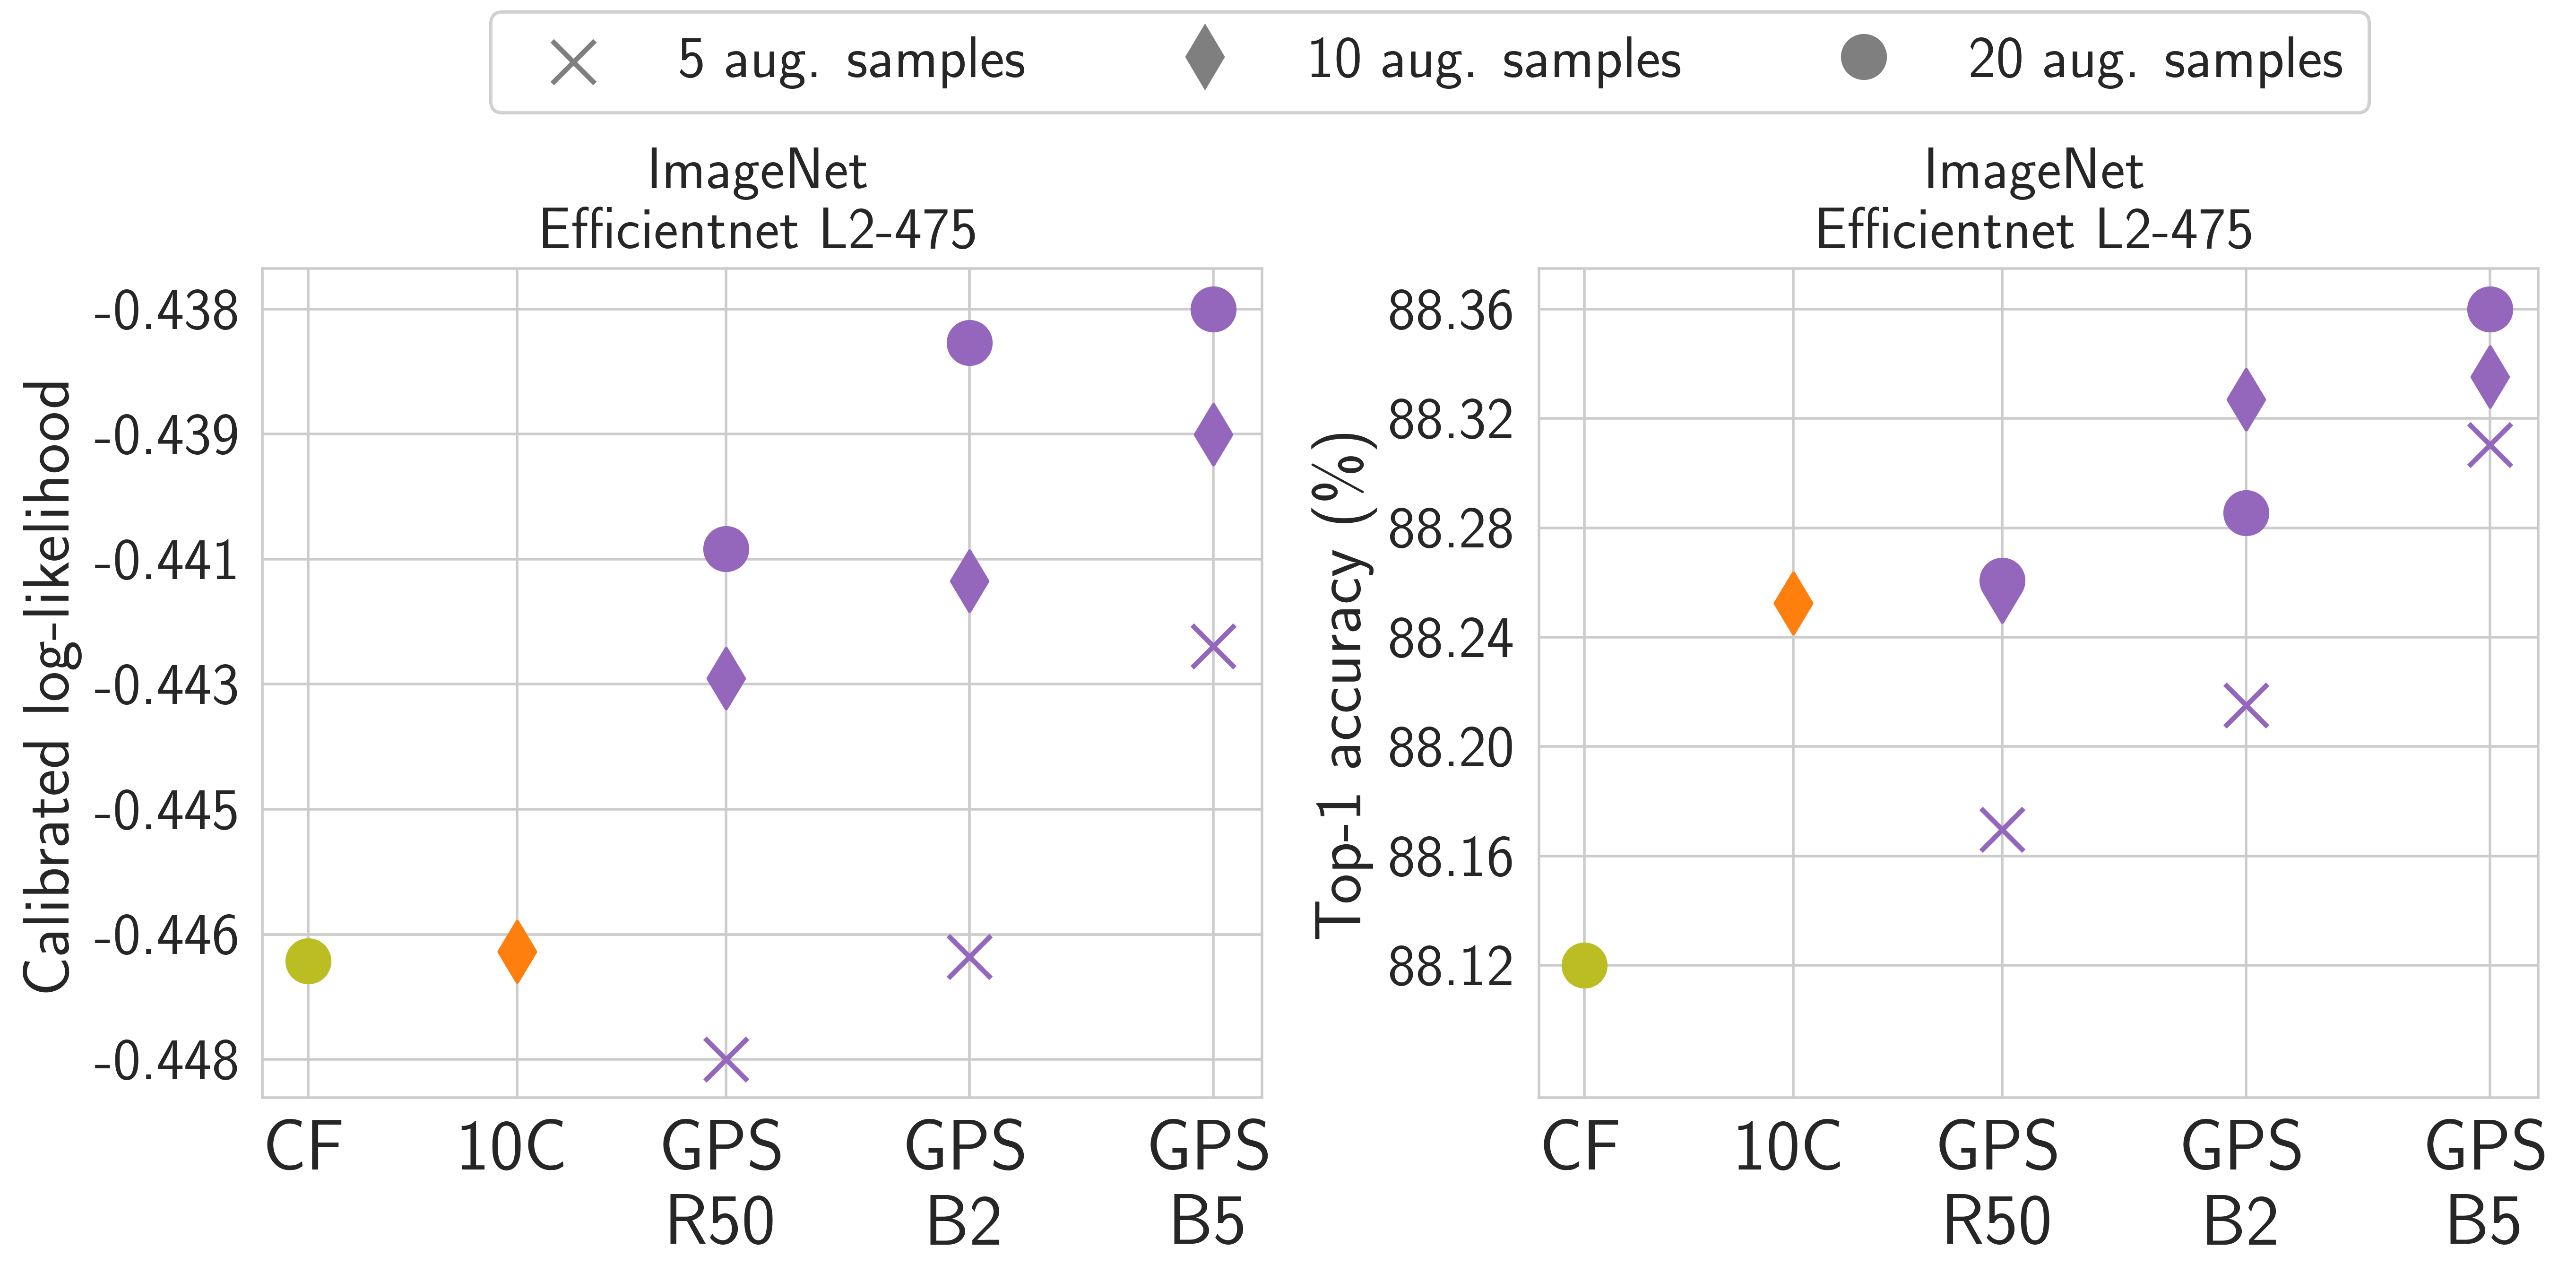

In [14]:
params = {'legend.fontsize': 18,
         'axes.labelsize': 18,
#          'figure.figsize': (6, 4),
         'axes.titlesize':18,
         'xtick.labelsize':18,
         'ytick.labelsize':18,
         'lines.markersize': 13,
         'legend.markerscale': 1.,
         'legend.labelspacing': 1.,
         'figure.subplot.hspace': 0.0,
         'figure.subplot.wspace': 0.00,
         }
pylab.rcParams.update(params)
mpl.rcParams['figure.dpi'] = 500
f = plt.figure(figsize=(11, 5))
# plt.subplots_adjust(wspace=2)

for m, metric in enumerate(['ll', 'acc']):
    poses = []

    models = ['tf_efficientnet_l2_ns_475']
    augs = ['cf', '10c', 'ra']
    sample_nums = [5, 10, 20]
    datasets = ['ImageNet']
   
    i = 1
    short_legend_augs_ordered = []
    for aug in augs:
        short_legend_augs_ordered.append(short_legend_augs[aug])

    for dataset in datasets:
        for model in models:
            plt.subplot(len(datasets), len(models)*2, m*1+i)
            i += 1
            lines = []
            min_ = +150000
            max_ = -100500


            for j, aug in enumerate(augs):
                plot_augs = []
                legends = []
                for sample_num in sample_nums:
                    if aug == 'cf' and sample_num < 15:
                        continue
                    marker = 'o'
                    if aug != 'cc' or sample_num == 20:
                        if aug == 'cc':
                            sample_num = 1
                            marker = '*'
                        if aug == '5c':
                            sample_num = 5
                            marker = 'x'
                        if aug == '10c':
                            sample_num = 10
                            marker = 'd'
                        if sample_num == 5 and (aug == 'ra' or aug == 'cf'):
                            marker = 'x'
                        if sample_num == 10 and (aug == 'ra' or aug == 'cf'):
                            marker = 'd' 
                        
                        if model == 'tf_efficientnet_l2_ns_475' and aug == 'ra':
                            for qw, inf in enumerate(['pols/resnet50_ll.npy', 
                                                      'pols/efficientnet_b2_ll.npy', 
                                                      'pols/tf_efficientnet_b5_ll.npy']):
                                q = 'dataset=="%s" and model=="%s" and method=="%s" and metric=="%s" and n_samples==%d and info=="%s"' % (dataset, model, aug, metric, sample_num, inf)
                                val = df.query(q)['mean']
                                val = val.item()
                                val *= 100 if metric == 'acc' else 1
                                
                                min_ = min(min_, val)
                                max_ = max(max_, val)


                                pos_x = j*0.6+qw*0.7
                                poses.append(pos_x)
                                plt.errorbar([pos_x], [val], c=colors_palette[colors_augs[aug]], elinewidth=3, alpha=0.5)
                                legends.append(plt.scatter([pos_x], [val], marker=marker,
                                            c=colors_palette[colors_augs[aug]]))
                        else:
                            q = 'dataset=="%s" and model=="%s" and method=="%s" and metric=="%s" and n_samples==%d' % (dataset, model, aug, metric, sample_num)
                            val = df.query(q)['mean']
                            val = val.item()
                            val *= 100 if metric == 'acc' else 1
                            
                            min_ = min(min_, val)
                            max_ = max(max_, val)

                            pos_x = j*0.6
                            poses.append(pos_x)
                            plt.errorbar([pos_x], [val], c=colors_palette[colors_augs[aug]], elinewidth=3, alpha=0.7)
                            legends.append(plt.scatter([pos_x], [val], marker=marker,
                                        c=colors_palette[colors_augs[aug]]))
                            
        
                plt.title(r'ImageNet'+'\n'+model_names[model])
                plt.xticks(poses, short_legend_augs_ordered)
#                 if model == 'tf_efficientnet_l2_ns_475':
                plt.yticks(np.linspace(min_, max_, 7))
                if metric == 'll':
                    from matplotlib.ticker import FormatStrFormatter
                    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                else:
                    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                ww = [r'GPS''\n'r'R50', r'GPS''\n'r'B2', r'GPS''\n'r'B5']
                plt.xticks(list(sorted(set(poses))), short_legend_augs_ordered[:-1]+ww, fontsize=22)
            
                plt.ylabel(metric_names[metric], fontsize=20)
    handles = []
    cross = plt.scatter([np.nan], [np.nan], color=colors_palette[-1], marker='x', 
                               label='5 aug. samples')
    handles.append(cross)
    circle = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker='d', linestyle='None',
                              label='10 aug. samples')
    handles.append(circle)
    circle = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker='o', linestyle='None',
                              label='20 aug. samples')
    handles.append(circle)

    f.legend(handles=handles, loc='upper center', ncol=3,
                bbox_to_anchor=(0.55, 1.1))
plt.tight_layout()
plt.savefig('imagenet_tr.pdf', bbox_inches='tight')

In [27]:
d=0.7
colors_augs = {'cf': d*3,
             'MGrid': 1,
             'ra': 2,
             'cc': 0,
             'MTrain': 4,
             '5c': d,
             '10c': d*2}

colors_augs = {'cf': 0,
             'MGrid': 1,
             'ra': 2,
             'cc': 3,
             'MTrain': 4,
             '5c': 6,
             '10c': 7}

In [28]:
cfs = ['''0 74.360 (25.640)
1 79.026 (20.974)
2 80.236 (19.764)
3 80.756 (19.244)
4 81.028 (18.972)
5 81.240 (18.760)
6 81.460 (18.540)
7 81.496 (18.504)
8 81.504 (18.496)
9 81.592 (18.408)
10 81.692 (18.308)
11 81.758 (18.242)
12 81.720 (18.280)
13 81.720 (18.280)
14 81.720 (18.280)
15 81.814 (18.186)
16 81.842 (18.158)
17 81.826 (18.174)
18 81.880 (18.120)
19 81.878 (18.122)''',
'''0 74.190 (25.810)
1 78.872 (21.128)
2 80.086 (19.914)
3 80.706 (19.294)
4 81.020 (18.980)
5 81.228 (18.772)
6 81.384 (18.616)
7 81.468 (18.532)
8 81.572 (18.428)
9 81.652 (18.348)
10 81.684 (18.316)
11 81.716 (18.284)
12 81.700 (18.300)
13 81.746 (18.254)
14 81.766 (18.234)
15 81.808 (18.192)
16 81.820 (18.180)
17 81.836 (18.164)
18 81.840 (18.160)
19 81.882 (18.118)''',
      '''0 74.336 (25.664)
1 78.922 (21.078)
2 80.174 (19.826)
3 80.714 (19.286)
4 81.142 (18.858)
5 81.298 (18.702)
6 81.382 (18.618)
7 81.524 (18.476)
8 81.556 (18.444)
9 81.612 (18.388)
10 81.724 (18.276)
11 81.752 (18.248)
12 81.752 (18.248)
13 81.826 (18.174)
14 81.846 (18.154)
15 81.806 (18.194)
16 81.806 (18.194)
17 81.822 (18.178)
18 81.830 (18.170)
19 81.846 (18.154)''']
cf = np.mean([list(map(lambda x: float(x.split()[1]), cf.split('\n'))) for cf in cfs], axis=0)

In [29]:
cfs = ['''0 74.302 (25.698)
1 79.034 (20.966)
2 80.158 (19.842)
3 80.804 (19.196)
4 81.076 (18.924)
5 81.290 (18.710)
6 81.470 (18.530)
7 81.546 (18.454)
8 81.628 (18.372)
9 81.682 (18.318)
10 81.736 (18.264)
11 81.780 (18.220)
12 81.766 (18.234)
13 81.810 (18.190)
14 81.814 (18.186)
15 81.822 (18.178)
16 81.874 (18.126)
17 81.880 (18.120)
18 81.904 (18.096)
19 81.878 (18.122)
20 81.898 (18.102)
21 81.904 (18.096)
22 81.928 (18.072)
23 81.920 (18.080)
24 81.914 (18.086)
25 81.918 (18.082)
26 81.936 (18.064)
27 81.882 (18.118)
28 81.888 (18.112)
29 81.878 (18.122)
30 81.890 (18.110)
31 81.890 (18.110)
32 81.902 (18.098)
33 81.902 (18.098)
34 81.874 (18.126)
35 81.924 (18.076)
36 81.936 (18.064)
37 81.950 (18.050)
38 81.960 (18.040)
39 81.906 (18.094)
40 81.904 (18.096)
41 81.932 (18.068)
42 81.940 (18.060)
43 81.922 (18.078)
44 81.922 (18.078)
45 81.948 (18.052)
46 81.926 (18.074)
47 81.910 (18.090)
48 81.928 (18.072)
49 81.950 (18.050)
50 81.964 (18.036)
51 81.962 (18.038)
52 81.938 (18.062)
53 81.944 (18.056)
54 81.958 (18.042)
55 81.948 (18.052)
56 81.948 (18.052)
57 81.922 (18.078)
58 81.914 (18.086)
59 81.922 (18.078)
60 81.934 (18.066)
61 81.936 (18.064)
62 81.952 (18.048)
63 81.966 (18.034)
64 81.974 (18.026)
65 81.950 (18.050)
66 81.956 (18.044)
67 81.968 (18.032)
68 81.980 (18.020)
69 81.984 (18.016)
70 81.974 (18.026)
71 81.978 (18.022)
72 81.998 (18.002)
73 81.986 (18.014)
74 81.998 (18.002)
75 82.014 (17.986)
76 81.998 (18.002)
77 82.006 (17.994)
78 82.004 (17.996)
79 81.992 (18.008)
80 82.018 (17.982)
81 82.020 (17.980)
82 82.028 (17.972)
83 82.034 (17.966)
84 82.038 (17.962)
85 82.034 (17.966)
86 82.010 (17.990)
87 82.020 (17.980)
88 82.024 (17.976)
89 82.024 (17.976)
90 82.026 (17.974)
91 82.022 (17.978)
92 82.038 (17.962)
93 82.038 (17.962)
94 82.030 (17.970)
95 82.040 (17.960)
96 82.040 (17.960)
97 82.048 (17.952)
98 82.026 (17.974)
99 82.044 (17.956)''']
cf = np.mean([list(map(lambda x: float(x.split()[1]), cf.split('\n'))) for cf in cfs], axis=0)

In [30]:
ras = ['''0 70.978 (29.022)
1 77.173 (22.827)
2 78.834 (21.166)
3 79.575 (20.425)
4 80.068 (19.932)
5 80.419 (19.581)
6 80.551 (19.449)
7 80.683 (19.317)
8 80.899 (19.101)
9 80.990 (19.010)
10 81.054 (18.946)
11 81.082 (18.918)
12 81.142 (18.858)
13 81.166 (18.834)
14 81.226 (18.774)
15 81.290 (18.710)
16 81.300 (18.700)
17 81.334 (18.666)
18 81.320 (18.680)
19 81.362 (18.638)''',
'''0 71.024 (28.976)
1 77.097 (22.903)
2 78.888 (21.112)
3 79.559 (20.441)
4 80.022 (19.978)
5 80.393 (19.607)
6 80.635 (19.365)
7 80.693 (19.307)
8 80.759 (19.241)
9 80.869 (19.131)
10 80.960 (19.040)
11 80.986 (19.014)
12 81.038 (18.962)
13 81.072 (18.928)
14 81.114 (18.886)
15 81.118 (18.882)
16 81.148 (18.852)
17 81.234 (18.766)
18 81.284 (18.716)
19 81.306 (18.694)''',
'''0 71.204 (28.796)
1 77.107 (22.893)
2 78.820 (21.180)
3 79.692 (20.308)
4 80.036 (19.964)
5 80.343 (19.657)
6 80.645 (19.355)
7 80.775 (19.225)
8 80.881 (19.119)
9 80.913 (19.087)
10 81.044 (18.956)
11 81.148 (18.852)
12 81.244 (18.756)
13 81.254 (18.746)
14 81.256 (18.744)
15 81.276 (18.724)
16 81.262 (18.738)
17 81.320 (18.680)
18 81.342 (18.658)
19 81.354 (18.646)''',
'''0 71.146 (28.854)
1 77.236 (22.764)
2 78.904 (21.096)
3 79.673 (20.327)
4 80.112 (19.888)
5 80.357 (19.643)
6 80.593 (19.407)
7 80.741 (19.259)
8 80.891 (19.109)
9 81.026 (18.974)
10 81.158 (18.842)
11 81.184 (18.816)
12 81.240 (18.760)
13 81.252 (18.748)
14 81.338 (18.662)
15 81.302 (18.698)
16 81.350 (18.650)
17 81.386 (18.614)
18 81.434 (18.566)
19 81.462 (18.538)''']
ram = np.mean([list(map(lambda x: float(x.split()[1]), ra.split('\n'))) for ra in ras], axis=0)
ras = np.std([list(map(lambda x: float(x.split()[1]), ra.split('\n'))) for ra in ras], axis=0)

In [31]:
ras = ['''0 71.242 (28.758)
1 77.352 (22.648)
2 78.940 (21.060)
3 79.629 (20.371)
4 80.008 (19.992)
5 80.409 (19.591)
6 80.621 (19.379)
7 80.639 (19.361)
8 80.817 (19.183)
9 80.925 (19.075)
10 80.960 (19.040)
11 81.032 (18.968)
12 81.128 (18.872)
13 81.186 (18.814)
14 81.290 (18.710)
15 81.284 (18.716)
16 81.320 (18.680)
17 81.266 (18.734)
18 81.338 (18.662)
19 81.358 (18.642)
20 81.460 (18.540)
21 81.456 (18.544)
22 81.422 (18.578)
23 81.456 (18.544)
24 81.480 (18.520)
25 81.488 (18.512)
26 81.464 (18.536)
27 81.534 (18.466)
28 81.532 (18.468)
29 81.558 (18.442)
30 81.575 (18.425)
31 81.589 (18.411)
32 81.641 (18.359)
33 81.627 (18.373)
34 81.643 (18.357)
35 81.637 (18.363)
36 81.653 (18.347)
37 81.657 (18.343)
38 81.659 (18.341)
39 81.605 (18.395)
40 81.562 (18.438)
41 81.615 (18.385)
42 81.649 (18.351)
43 81.641 (18.359)
44 81.631 (18.369)
45 81.667 (18.333)
46 81.699 (18.301)
47 81.687 (18.313)
48 81.685 (18.315)
49 81.677 (18.323)
50 81.687 (18.313)
51 81.669 (18.331)
52 81.663 (18.337)
53 81.657 (18.343)
54 81.663 (18.337)
55 81.661 (18.339)
56 81.671 (18.329)
57 81.663 (18.337)
58 81.665 (18.335)
59 81.681 (18.319)
60 81.679 (18.321)
61 81.701 (18.299)
62 81.687 (18.313)
63 81.701 (18.299)
64 81.687 (18.313)
65 81.663 (18.337)
66 81.669 (18.331)
67 81.659 (18.341)
68 81.657 (18.343)
69 81.659 (18.341)
70 81.663 (18.337)
71 81.677 (18.323)
72 81.695 (18.305)
73 81.685 (18.315)
74 81.721 (18.279)
75 81.723 (18.277)
76 81.721 (18.279)
77 81.727 (18.273)
78 81.687 (18.313)
79 81.693 (18.307)
80 81.691 (18.309)
81 81.695 (18.305)
82 81.707 (18.293)
83 81.681 (18.319)
84 81.701 (18.299)
85 81.679 (18.321)
86 81.689 (18.311)
87 81.691 (18.309)
88 81.715 (18.285)
89 81.721 (18.279)
90 81.735 (18.265)
91 81.739 (18.261)
92 81.723 (18.277)
93 81.743 (18.257)
94 81.721 (18.279)
95 81.731 (18.269)
96 81.717 (18.283)
97 81.703 (18.297)
98 81.705 (18.295)
99 81.685 (18.315)''']
ram = np.mean([list(map(lambda x: float(x.split()[1]), ra.split('\n'))) for ra in ras], axis=0)
ras = np.std([list(map(lambda x: float(x.split()[1]), ra.split('\n'))) for ra in ras], axis=0)

In [32]:
colors = {'efficientnet_b2': 'r',
          'resnet50': 'g',
          'tf_efficientnet_b5': 'b'
         }

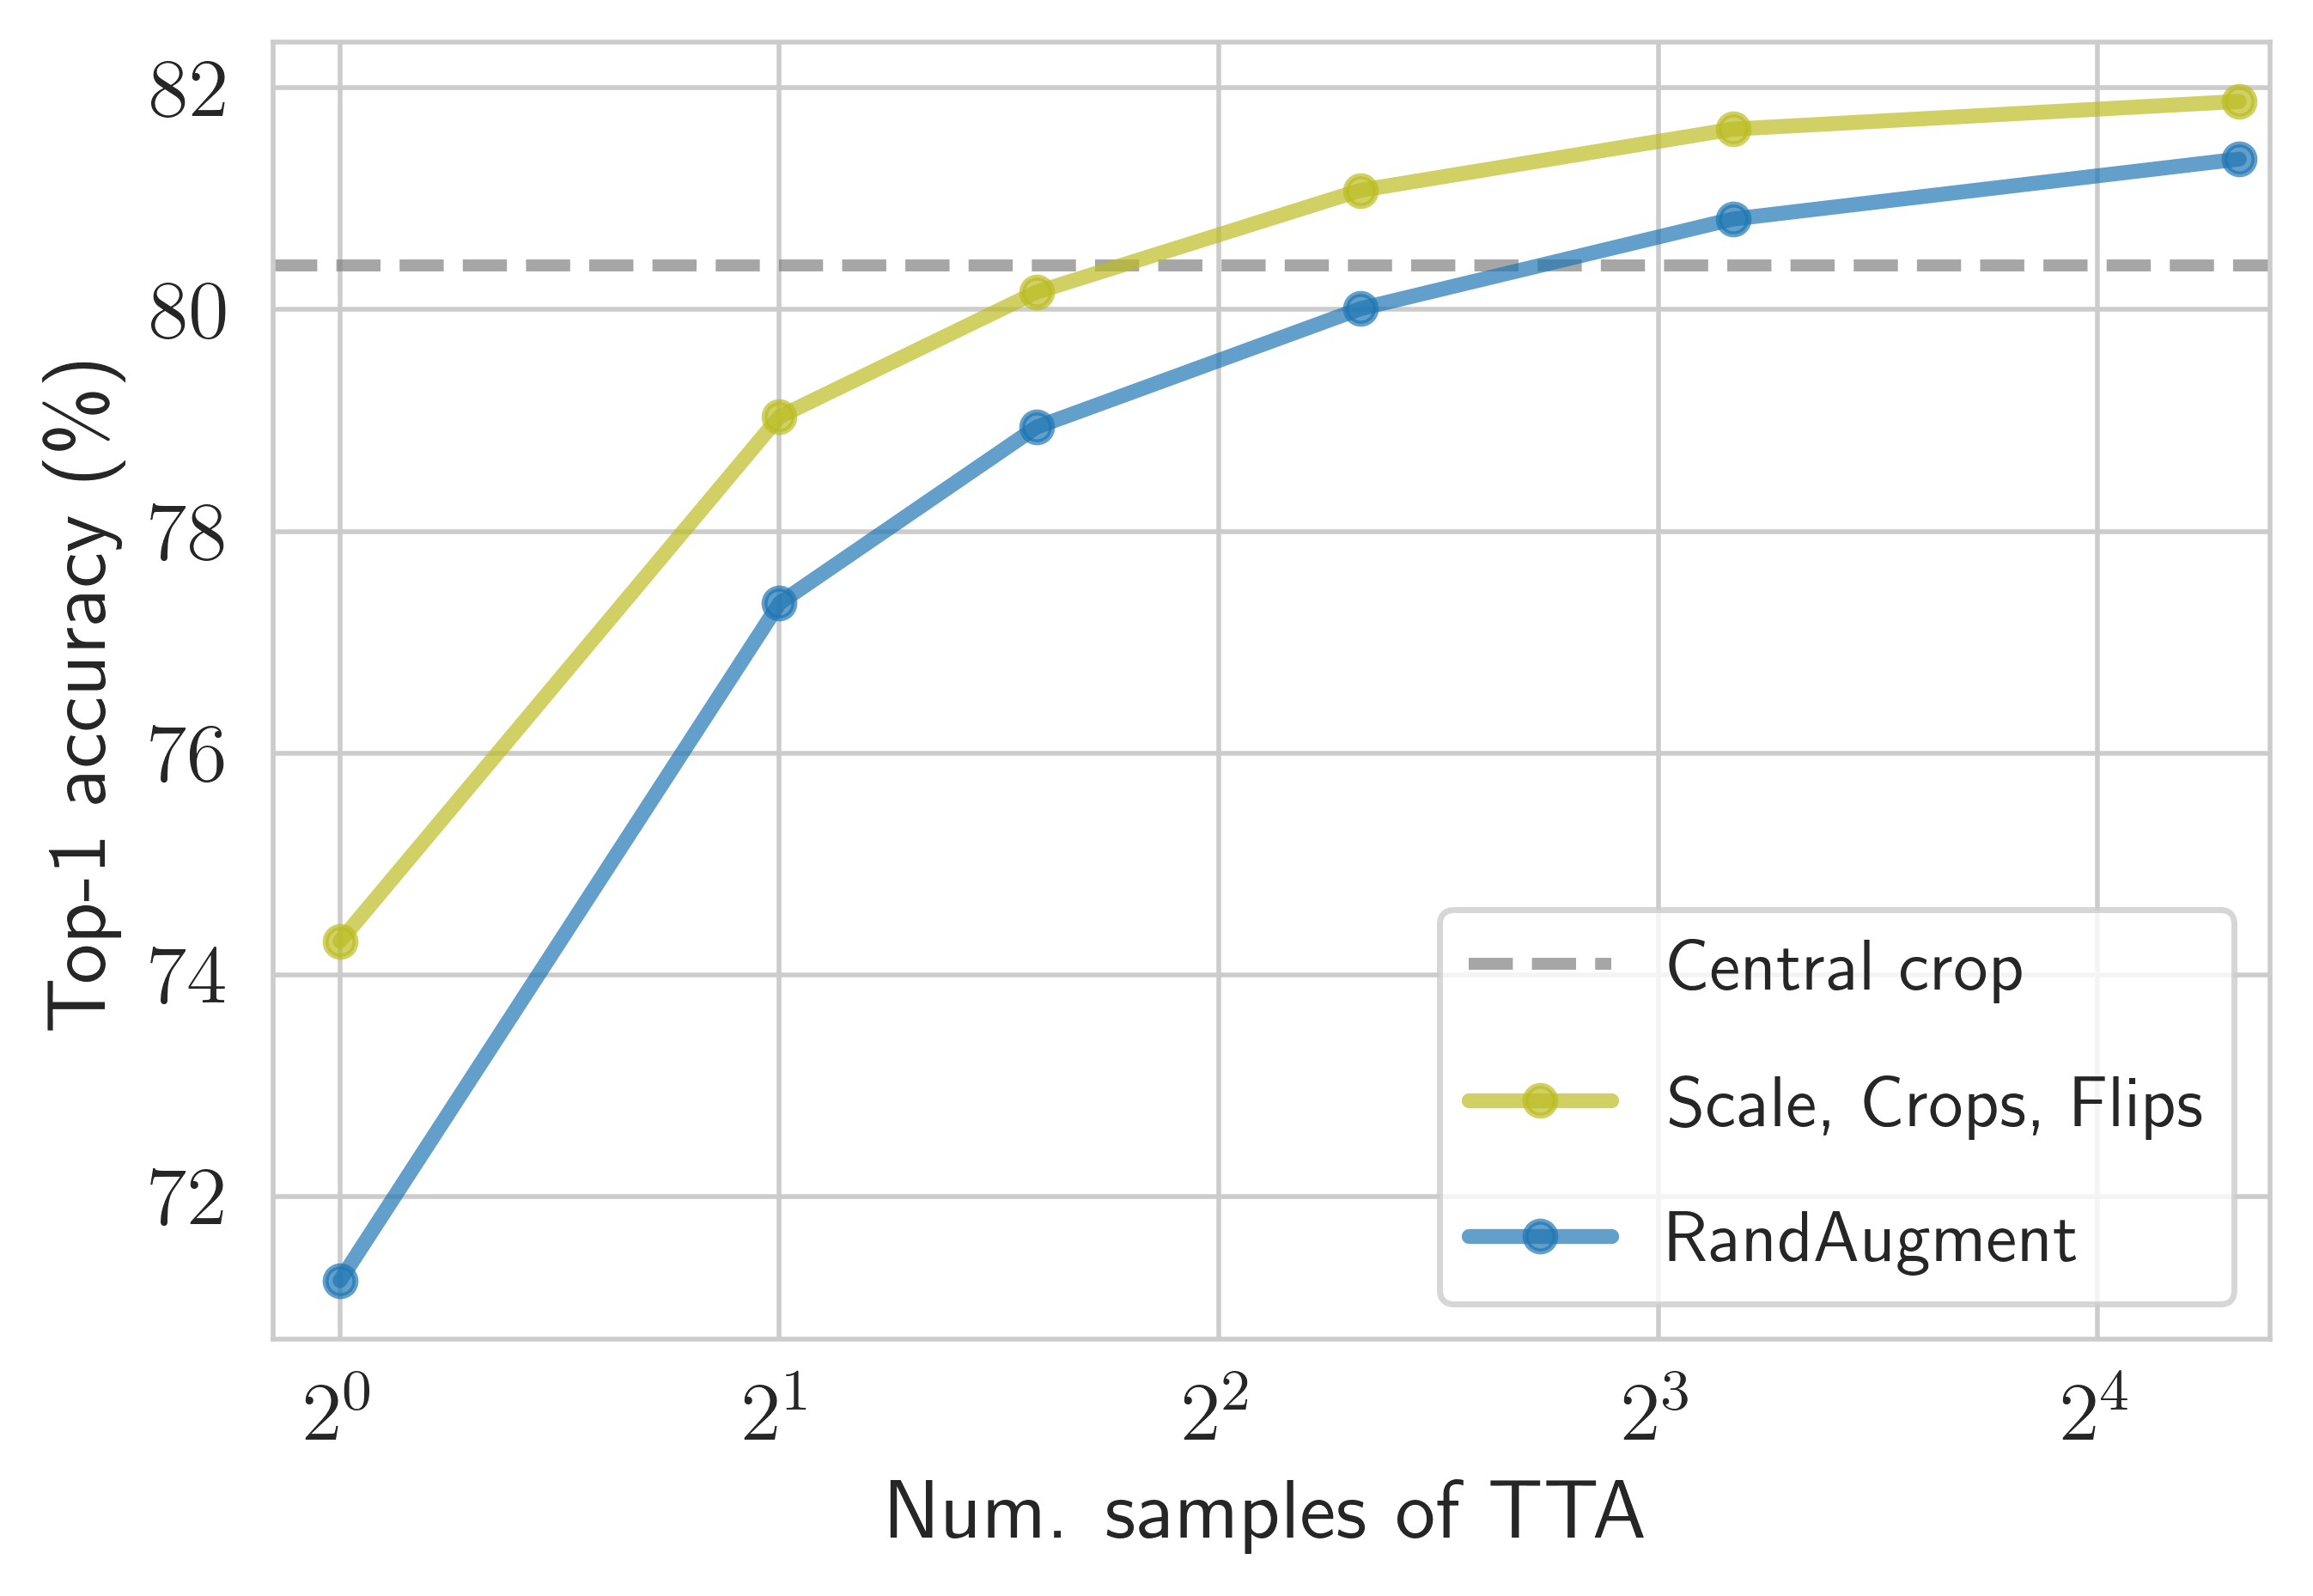

In [33]:
params = {'legend.fontsize': 14,
             'axes.labelsize': 14,
             'axes.titlesize':14,
             'xtick.labelsize':14,
             'ytick.labelsize':14,
             'lines.markersize': 10,
             'legend.markerscale': 1.,
             'legend.labelspacing': 1.,
             'figure.subplot.hspace': 0.01,
             'figure.subplot.wspace': 0.05}
pylab.rcParams.update(params)
    
x = np.array(range(1, 21))
idxs = [0, 1, 2, 4, 8, 19]
plt.plot([0.9, 21], [80.402, 80.402], '--', c='gray', lw=2, alpha=0.7, label='Central crop')
plt.plot(x[idxs], cf[idxs], '-o', ms=5, lw=2.5, label='Scale, Crops, Flips', alpha=0.7, c=colors_palette[colors_augs['cf']])
plt.plot(x[idxs], ram[idxs], '-o', ms=5, lw=2.5, label='RandAugment', alpha=0.7,  c=colors_palette[colors_augs['MTrain']])
plt.xlim(0.9, 21)
plt.gca().set_xscale('log', basex=2)
plt.ylabel('Top-1 accuracy (\%)')
plt.xlabel('Num. samples of TTA')
plt.legend(fontsize=12, ncol=1)
plt.savefig('example.pdf', bbox_inches='tight')